<a href="https://colab.research.google.com/github/basel5621/depi-project/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1m2iJT80nunVd2EHHByHPrkQhQUxGnp9a' -O train.csv

--2024-10-06 19:11:04--  https://docs.google.com/uc?export=download&id=1m2iJT80nunVd2EHHByHPrkQhQUxGnp9a
Resolving docs.google.com (docs.google.com)... 142.250.99.113, 142.250.99.101, 142.250.99.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1m2iJT80nunVd2EHHByHPrkQhQUxGnp9a&export=download [following]
--2024-10-06 19:11:05--  https://drive.usercontent.google.com/download?id=1m2iJT80nunVd2EHHByHPrkQhQUxGnp9a&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.203.132, 2607:f8b0:400e:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66684319 (64M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  63.59M  60.2MB/s    in 1

In [ ]:
df_train = pd.read_csv('train.csv',encoding="ISO-8859-1")

In [ ]:
df_train.head()

,cleaned_text,label
0,going another signing north cause live blackpo...,0
1,cowardly loser seek racism weapon not win,1
2,checking much talked twitter thanks jen,1
3,feel hot im kind getty coughy scratchy throat,0
4,yay emily twitter exciting hope summer going w...,1


In [ ]:
X=df_train['cleaned_text'].astype(str)
y=df_train['label']

X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1440000 entries, 0 to 1439999
Series name: cleaned_text
Non-Null Count    Dtype 
--------------    ----- 
1440000 non-null  object
dtypes: object(1)
memory usage: 11.0+ MB


In [ ]:
X_token=X.apply(word_tokenize)
model_w2v = Word2Vec(X_token, vector_size=200, window=5, min_count=1, workers=8, sg=0)

In [ ]:
print(model_w2v.wv.most_similar('happy'))

[('proud', 0.5611803531646729), ('celebrating', 0.5402633547782898), ('woofuckinghoo', 0.5344820618629456), ('meampsteves', 0.529830276966095), ('muttis', 0.5281973481178284), ('tomarrowgreat', 0.5231884717941284), ('nitevolimultiplycom', 0.5193063020706177), ('wishesthey', 0.5131116509437561), ('crapagainand', 0.5077494978904724), ('grandmon', 0.5065884590148926)]


In [ ]:
print(model_w2v.wv.most_similar('love'))

[('adore', 0.6337231397628784), ('loved', 0.6121105551719666), ('luv', 0.6009416580200195), ('lt3', 0.5745826959609985), ('amazing', 0.5489721298217773), ('loving', 0.544588565826416), ('awesome', 0.513495147228241), ('reminds', 0.4965193271636963), ('incredible', 0.4867837727069855), ('Ã¢', 0.4729740023612976)]


In [ ]:
model_w2v.save("word2vec.model")

In [ ]:
loaded_model = Word2Vec.load("word2vec.model")

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X)

max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq , maxlen=max_len , padding='post')
vocab_size

406547

In [ ]:
embedding_dim = model_w2v.vector_size  # 300 in your case
embedding_matrix = np.zeros((vocab_size, model_w2v.vector_size))
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [ ]:
embedding_matrix.shape

(406547, 200)

In [ ]:
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense ,Dropout
from tensorflow.keras import layers


BI_LSTM_model = Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size, output_dim=model_w2v.vector_size, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

BI_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

BI_LSTM_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 37, 200)             │      81,309,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 37, 512)             │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,311,129 (313.99 MB)

 Trainable params: 1,001,729 (3.82 MB)

 Non-trainable params: 81,309,400 (310.17 MB)

In [ ]:
BI_history=BI_LSTM_model.fit(X_train_padded, y, epochs=100, batch_size=512, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 134s 50ms/step - accuracy: 0.7618 - loss: 0.8530 - val_accuracy: 0.7792 - val_loss: 0.4790
Epoch 2/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 126s 50ms/step - accuracy: 0.7782 - loss: 0.4817 - val_accuracy: 0.7811 - val_loss: 0.4757
Epoch 3/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 127s 50ms/step - accuracy: 0.7809 - loss: 0.4782 - val_accuracy: 0.7765 - val_loss: 0.4820
Epoch 4/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 127s 50ms/step - accuracy: 0.7823 - loss: 0.4745 - val_accuracy: 0.7825 - val_loss: 0.4700
Epoch 5/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.7830 - loss: 0.4750 - val_accuracy: 0.7840 - val_loss: 0.4690
Epoch 6/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 127s 50ms/step - accuracy: 0.7829 - loss: 0.4756 - val_accuracy: 0.7856 - val_loss: 0.4686
Epoch 7/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.7842 - loss: 0.4706 - val_accuracy: 0.7835 - val_loss: 0.4718
Epoch 8/100
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - ac

<Axes: >

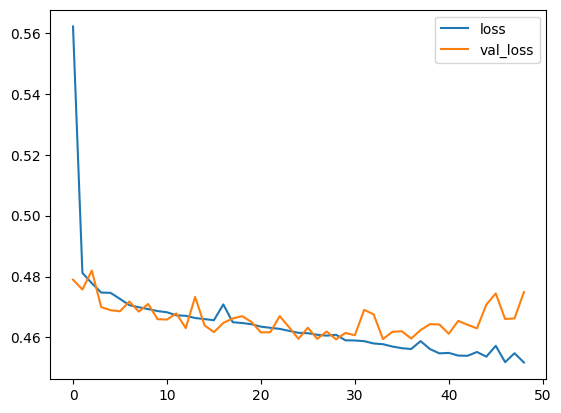

In [ ]:
df_hist_BI=pd.DataFrame(BI_history.history)
df_hist_BI[['loss','val_loss']].plot()

In [ ]:
BI_LSTM_model.save("BI_LSTM_model.keras")